# Spring 2024 6.8200 Computational Sensorimotor Learning Assignment 4

In this assignment, we will work on learning from demonstrations.

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are **145** total points to be had in this PSET and an addition **30 bonus** points.  `ctrl-f` for "pts" to ensure you don't miss questions.

In [ ]:
!pip install numpy==1.23.1 > /dev/null 2>&1
!pip install "setuptools<58.0.0" > /dev/null 2>&1
!pip install pybullet > /dev/null 2>&1
!pip install git+https://github.com/taochenshh/easyrl.git > /dev/null 2>&1
!pip install git+https://github.com/Improbable-AI/airobot.git > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt install chromium-browser xvfb
!apt install xvfb

In [2]:
import os
import torch
import gym
import pickle
import pprint
import time
import pybullet as p
import pybullet_data as pd
import pybullet_envs
import airobot as ar
import numpy as np
np.bool = np.bool_
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from typing import Any
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pylab
from dataclasses import dataclass
from airobot import Robot
from airobot.utils.common import quat2euler
from airobot.utils.common import euler2quat
from gym import spaces
from gym.envs.registration import registry, register
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.notebook import tqdm
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pathlib import Path
from copy import deepcopy
from itertools import count
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.utils.common import save_traj
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.agents.base_agent import BaseAgent
from easyrl.utils.torch_util import DictDataset
from easyrl.utils.torch_util import load_state_dict
from easyrl.utils.torch_util import load_torch_model
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.torch_util import save_model
from easyrl.utils.torch_util import action_entropy
from easyrl.utils.torch_util import action_from_dist
from easyrl.utils.torch_util import action_log_prob
from easyrl.utils.torch_util import clip_grad
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from easyrl.utils.torch_util import freeze_model
from easyrl.utils.torch_util import move_to
from easyrl.utils.torch_util import torch_float
from easyrl.utils.torch_util import torch_to_np
from base64 import b64encode
from IPython import display as ipythondisplay
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


In [3]:
from google.colab import drive

drive.mount('/content/drive/')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive/


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
def play_video(video_dir, video_file=None, video_id=None):
    """
      Parameters:
      - video_dir (str): The directory path where video files are located. This is used if `video_file` is not provided.
      - video_file (str, optional): The path to a specific video file to play. If None, the function searches for
        'render_video.mp4' in `video_dir`.

      Returns:
        - None: This function does not return any value. It directly displays the video within the IPython notebook.
    """
    if video_file is None:
        video_dir = Path(video_dir)
        video_files = list(video_dir.glob(f'**/render_video.mp4'))
        if video_id is not None:
            video_files = [x for x in video_files if f'{video_id:06d}' in x.as_posix()]
        video_files.sort()
        video_file = video_files[-1]
    else:
        video_file = Path(video_file)
    compressed_file = video_file.parent.joinpath('comp.mp4')
    os.system(f"ffmpeg -i {video_file} -filter:v 'setpts=2.0*PTS' -vcodec libx264 {compressed_file.as_posix()}")
    mp4 = open(compressed_file.as_posix(),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    ipythondisplay.display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

# read tf log file
def read_tf_log(log_dir):
    """
        Parameters:
      - log_dir (str): The directory path where TensorFlow log files are located. The function searches for files
        starting with 'events.' within this directory and its subdirectories.

      Returns:
      - Tuple[List[int], List[float], List[float]]: A tuple containing three lists:
          - steps (List[int]): A list of steps at which each episode's success rate was recorded.
          - returns (List[float]): A list of mean returns for each episode.
          - success_rate (List[float]): A list of success rates for each episode.
        Returns None if no log files are found or if there's an error in extracting scalar values.
    """
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]
    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()
    try:
        scalar_success = event_acc.Scalars('train/episode_success')
        success_rate = [x.value for x in scalar_success]
        steps = [x.step for x in scalar_success]
        scalar_return = event_acc.Scalars('train/episode_return/mean')
        returns = [x.value for x in scalar_return]
    except:
        return None
    return steps, returns, success_rate


def plot_curves(data_dict, title):
    """
        Parameters:
      - data_dict (Dict[str, List[List[float]]]): A dictionary where each key is a label string and each value is a list
        containing two lists: the first list for x-values and the second for y-values of the curve.
      - title (str): The title of the plot.

      This function does not return anything. It directly displays the plot.
    """
    # {label: [x, y]}
    fig, ax = plt.subplots(figsize=(4, 3))
    labels = data_dict.keys()
    for label, data in data_dict.items():
        x = data[0]
        y = data[1]
        ax.plot(x, y, label=label)
    ax.set_title(title)
    ax.legend()

def set_random_seed(seed):
    """
        Parameters:
       - seed (int): set random seed.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

# set random seed
seed = 0
set_random_seed(seed=seed)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Environment (Pusher)

In this assignment, we will use the Pusher environment that we used in HW3. We modified the environment so that the goal locations are randomly sampled within a small region. Below, we specify the goal bounds using the variable self._goal_bounds.

In [6]:
class URRobotPusherGym(gym.Env):
    """
    A gym environment for a robot arm to learn pushing objects towards a goal position in a simulated environment.

    Attributes:
    - action_space (gym.spaces.Box): The action space of the environment, defining the allowed actions.
    - observation_space (gym.spaces.Box): The observation space of the environment, defining the structure of observations.
    - robot (Robot): The robot object, providing an interface to control and retrieve information from the robot arm.
    """
    def __init__(self,
                 action_repeat=10,
                 gui=False,
                 max_episode_length=30,
                 dist_threshold=0.05):
        """
        Initializes the gym environment with specified parameters.
        Parameters:
        - action_repeat (int, optional): The number of times an action is repeated. Defaults to 10.
        - gui (bool, optional): If True, the PyBullet GUI is enabled for visualization. Defaults to False.
        - max_episode_length (int, optional): The maximum length of an episode. Defaults to 30.
        - dist_threshold (float, optional): The distance threshold to consider the task as successful. Defaults to 0.05.
        """
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self._goal_bounds = np.array([[0.3, 0.65],  # [xmin, xmax]
                                      [0.0, 0.25]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.2, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        self._box_pos = np.array([0.45, -0.1, 0.996])
        self._box_id = self.robot.pb_client.load_geom('cylinder', size=[0.05, 0.05], mass=1.,
                                                      base_pos=self._box_pos,
                                                      rgba=[1., 0.6, 0.6, 1])

        self.robot.pb_client.changeDynamics(self._box_id, -1, lateralFriction=0.9)

        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._start_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)
        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._goal_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.04
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state and returns the initial observation.

        Returns:
        - state (np.ndarray): The initial observation of the environment after reset.
        """
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self.robot.pb_client.reset_body(self._box_id, base_pos=self._box_pos)

        starts = self._goal_bounds[:, 0]
        ends = self._goal_bounds[:, 1]
        width = ends - starts
        # different from HW3, we are setting the goal to a random location
        ran = np.random.random(2)
        goal_pos = starts + width * ran
        goal_pos = np.append(goal_pos, 1)
        self._goal_pos = goal_pos
        self.robot.pb_client.reset_body(self._goal_urdf_id, base_pos=self._goal_pos)

        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action):
        """
        Applies an action to the environment and returns the next state, reward, done flag, and additional information.

        Parameters:
        - action (np.ndarray): The action to be applied to the environment.

        Returns:
        - state (np.ndarray): The next state of the environment after applying the action.
        - reward (float): The reward resulting from the action.
        - done (bool): The done flag indicating if the episode has ended.
        - info (dict): Additional information about the step, including success and collision indicators.
        """
        previous_state = self._get_obs()
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()

        reward, info = self._get_reward(state=state, action=action, previous_state=previous_state)
        done = self._t >= self._max_episode_length or info['success']
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state, action, previous_state):
        """
        Calculates the reward for the current action based on the state of the environment and the action taken.

        Parameters:
        - state (np.ndarray): The current state of the environment, including the gripper's and object's positions.
        - action (np.ndarray): The action taken by the agent.
        - previous_state (np.ndarray): The state of the environment before the current action was taken.

        Returns:
        - reward (float): The calculated reward based on the distance of the object to the goal, the distance between the gripper and the object, and whether the object has reached the goal.
        - info (dict): A dictionary containing additional information about the current step, including whether the goal has been successfully reached ('success': bool).
        """
        object_pos = state[2:4]
        dist_to_goal = np.linalg.norm(object_pos - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        gripper_pos = state[:2]
        prev_object_pos = previous_state[2:4]
        prev_dist_to_goal = np.linalg.norm(prev_object_pos - self._goal_pos[:2])

        gripper_obj_dist = np.linalg.norm(gripper_pos - object_pos)
        reach_reward = -gripper_obj_dist
        touch_reward = int(gripper_obj_dist < 0.08) * 0.03 if dist_to_goal < prev_dist_to_goal else 0

        push_reward = np.exp(-dist_to_goal * 8) * 1. if touch_reward > 0 else 0
        if success:
            push_reward += 10
        reward = touch_reward + push_reward + reach_reward
        info = dict(success=success)
        return reward, info

    def _get_obs(self):
        """
        Retrieves the current observation of the environment, which includes the position of the gripper and the position of the object relative to the goal.

        Returns:
        - state (np.ndarray): An array containing the current positions of the gripper and the object, as well as the goal position.
        """
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        object_pos, object_quat = self.robot.pb_client.get_body_state(self._box_id)[:2]
        state = np.concatenate([gripper_pos, object_pos[:2], self._goal_pos[:2]])
        return state

    def _apply_action(self, action):
        """
        Applies the given action to the environment, moving the robot's end effector accordingly.

        Parameters:
        - action (np.ndarray): The desired movement action for the robot's end effector, specified as a displacement in the x and y directions.

        Returns:
        - (bool): False if the new position is within predefined bounds (collision).
        """
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        return False

    def render(self, mode='human', **kwargs):
        """
        Renders the environment. If mode is 'human', the environment is visualized.

        Parameters:
        - mode (str, optional): The mode of rendering. Defaults to 'human'.

        Returns:
        - rgb (np.ndarray): An RGB array of the scene if mode is not 'human'.
        """
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb


module_name = __name__

env_name = 'URPusher-v1'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotPusherGym',
)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


# Learning from Demonstrations

To generate a dataset of demonstrations to learn from, we've provided you a pre-trained expert model.

In [ ]:
# Download the expert model
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1vlOBeo3caEbl17JEEyxRWbCnFZ--dyXH' -O pusher_expert_model.pt

## Utility functions

In [8]:
def create_actor(env):
    """
    Creates an actor model for a given environment using a Diagonal Gaussian policy architecture.
    https://github.com/taochenshh/easyrl/blob/master/easyrl/models/diag_gaussian_policy.py

    Parameters:
    - env (gym.Env): The environment for which the actor is being created. The observation and action spaces of the environment are used to define the input and output dimensions of the model.

    Returns:
    - actor (nn.Module): An instance of `DiagGaussianPolicy`, initialized with the specified architecture and ready for training or inference.
    """
    ob_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    actor_body = MLP(input_size=ob_dim,
                    hidden_sizes=[64],
                    output_size=64,
                    hidden_act=nn.Tanh,
                    output_act=nn.Tanh)
    actor = DiagGaussianPolicy(actor_body,
                               in_features=64,
                               action_dim=action_dim)
    return actor

def load_expert_agent(env, device, expert_model_path='pusher_expert_model.pt'):
    """
    Loads an expert agent model from a specified file path.

    Parameters:
    - env (gym.Env): The environment associated with the expert agent. Used to create an actor model with appropriate dimensions.
    - device (torch.device): The device on which the model should be loaded.
    - expert_model_path (str, optional): The file path to the expert model's state dictionary. Defaults to 'pusher_expert_model.pt'.

    Returns:
    - expert_agent (BasicAgent): A `BasicAgent` instance with the actor loaded from the specified checkpoint.
    """
    expert_actor = create_actor(env=env)
    expert_agent = BasicAgent(actor=expert_actor)
    print(f'Loading expert model from: {expert_model_path}.')
    ckpt_data = torch.load(expert_model_path, map_location=f'cpu')
    load_state_dict(expert_agent.actor,
                    ckpt_data['actor_state_dict'])
    freeze_model(expert_agent.actor)
    return expert_agent

def generate_demonstration_data(expert_agent, env, num_trials):
    """
    Generates demonstration data by running inference with an expert agent in the environment.

    Parameters:
    - expert_agent (BasicAgent): The expert agent used to generate the demonstrations.
    - env (gym.Env): The environment in which the agent will generate demonstrations.
    - num_trials (int): The number of trials to run for generating demonstrations.

    Returns:
    - trajs (list): A list of trajectories generated by the expert agent. Each trajectory contains observations, actions, rewards, and other trajectory-specific information collected during the trial.
    """
    return run_inference(expert_agent, env, num_trials, return_on_done=True)

def run_inference(agent, env, num_trials, return_on_done=False, sample=True, disable_tqdm=False, render=False):
    """
    Runs inference with a given agent in the environment for a specified number of trials.

    Parameters:
    - agent (BasicAgent): The agent to run inference with.
    - env (gym.Env): The environment in which to run the agent.
    - num_trials (int): The number of trials to run.
    - return_on_done (bool, optional): Whether to return immediately after an episode is done. Defaults to False.
    - sample (bool, optional): Whether to sample actions from the policy distribution. Defaults to True.
    - disable_tqdm (bool, optional): Whether to disable the tqdm progress bar. Defaults to False.
    - render (bool, optional): Whether to render the environment. Defaults to False.

    Returns:
    - trajs (list): A list of trajectories from the inference runs. Each trajectory contains observations, actions, rewards, and other episode-specific information.
    """
    runner = EpisodicRunner(agent=agent, env=env)
    trajs = []
    for trial_id in tqdm(range(num_trials), desc='Run', disable=disable_tqdm):
        env.reset()
        traj = runner(time_steps=cfg.alg.episode_steps,
                      sample=sample,
                      return_on_done=return_on_done,
                      evaluation=True,
                      render_image=render)
        trajs.append(traj)
    return trajs

def eval_agent(agent, env, num_trials, disable_tqdm=False, render=False):
    """
    Evaluates the given agent in the environment across a specified number of trials.

    Parameters:
    - agent (BasicAgent): The agent to evaluate.
    - env (gym.Env): The environment in which to evaluate the agent.
    - num_trials (int): The number of trials to perform for the evaluation.
    - disable_tqdm (bool, optional): Whether to disable the tqdm progress bar during evaluation. Defaults to False.
    - render (bool, optional): Whether to render the environment during evaluation. Defaults to False.

    Returns:
    - success_rate (float): The rate of successful episodes.
    - ret_mean (float): The mean return across all trials.
    - ret_std (float): The standard deviation of the return across all trials.
    - rets (list): A list of returns from each trial.
    - successes (list): A list of boolean values indicating whether each trial was successful.
    """
    trajs = run_inference(agent, env, num_trials, return_on_done=True,
                          disable_tqdm=disable_tqdm, render=render)
    tsps = []
    successes = []
    rets = []
    for traj in trajs:
        tsps = traj.steps_til_done.copy().tolist()
        rewards = traj.raw_rewards
        infos = traj.infos
        for ej in range(rewards.shape[1]):
            ret = np.sum(rewards[:tsps[ej], ej])
            rets.append(ret)
            successes.append(infos[tsps[ej] - 1][ej]['success'])
        if render:
            save_traj(traj, 'tmp')
    ret_mean = np.mean(rets)
    ret_std = np.std(rets)
    success_rate = np.mean(successes)
    return success_rate, ret_mean, ret_std, rets, successes

In [9]:
@dataclass
class BasicAgent:
    """
    A basic agent class for reinforcement learning, encapsulating a policy actor model.

    Attributes:
    - actor (nn.Module): The neural network model that acts as the policy actor for the agent.

    Methods:
    - get_action(ob, sample=True, *args, **kwargs): Generates an action for a given observation by sampling from the policy actor's output distribution. Returns the action along with information such as log probability and entropy of the action.
    """
    actor: nn.Module

    def __post_init__(self):
        move_to([self.actor],
                device=cfg.alg.device)

    @torch.no_grad()
    def get_action(self, ob, sample=True, *args, **kwargs):
        t_ob = torch_float(ob, device=cfg.alg.device)
        # the policy returns a multi-variate gaussian distribution
        act_dist, _ = self.actor(t_ob)
        # sample from the distribution
        action = action_from_dist(act_dist,
                                  sample=sample)
        # get the log-probability of the sampled actions
        log_prob = action_log_prob(action, act_dist)
        # get the entropy of the action distribution
        entropy = action_entropy(act_dist, log_prob)
        action_info = dict(
            log_prob=torch_to_np(log_prob),
            entropy=torch_to_np(entropy),
        )
        return torch_to_np(action), action_info


In [10]:
def set_configs(exp_name='bc'):
    set_config('ppo')
    cfg.alg.seed = seed
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 150
    cfg.alg.max_steps = 600000
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += f'/{exp_name}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'====================================')

## Generating demonstrations

Now that you've downloaded the expert policy model, let's load the expert agent.

In [ ]:
# load the expert agent
set_configs()
env = make_vec_env(cfg.alg.env_name,
                   cfg.alg.num_envs,
                   seed=cfg.alg.seed)
expert_agent = load_expert_agent(env, device=cfg.alg.device)

Agent is a class encapsulating has an `actor` network that returns a tuple in its forward pass: `(action_distribution, output_of_MLP)`

In [ ]:
expert_agent

Let's check how good the expert policy is and visualize its performance using `eval_agent` which takes an agent and evaluates it in a specified environment.

This function will return to you the succes rate over all trajectories, the mean and standard deviation of total returns, the total returns of each trajectory, and the success of each trajectory.

In [ ]:
success_rate, ret_mean, ret_std, rets, successes = eval_agent(expert_agent, env, 500)
# you might see some variance in the success rate here,
# if you rollout the policies more times, the success rate will be more stable
print(f'\n Expert policy success rate:{success_rate}') # It takes < 1 minute in T4.

In [ ]:
# if you set `render=True`, it will save each evaluation trajectory in `tmp`
# and you can use `play_video` to visually check the trajectory
success_rate, ret_mean, ret_std, rets, successes = eval_agent(expert_agent, env, 5, render=True) # It takes < 1 minute in T4.

In [15]:
play_video('tmp', video_id=2)

Finally, let's generate a dataset of 50 expert demonstrations.
Note that data is usually acquired not from optimal deomonstrations but from the real world.

In [16]:
# Each trajectory is a dataclass containing a list of objects containing "step data".
# Step data contains- observation: ndarry[float], action:ndarry[float], action_info: Dict[log_prob: 1x1 ndarry[float], entropy: 1x1 ndarry[float]],
#                     next_observation: ndarry[float], reward: 1x1 ndarry[float], done: 1x1 ndarry[bool]

# Trajectory class: https://github.com/taochenshh/easyrl/blob/master/easyrl/utils/data.py

expert_trajs = generate_demonstration_data(expert_agent=expert_agent,
                                           env=env,
                                           num_trials=50) # It takes < 1 minute in T4.


Run:   0%|          | 0/50 [00:00<?, ?it/s]

## Behavior Cloning (BC)

**Q1: (30 pts total)** Now that we have expert demonstrations, let's use supervised learning (behavior cloning) to clone expert behavior and analyze the results.

Basic methodology for this task:
1. Obtain expert data (Done!)

(TO-DO)
2. Instantiate model using the `create_actor(env)` function, which given an environment creates a special torch.nn.Module that uses a diagonal gaussian policy. The model takes an observation as input and outputs types `(torch.Distribution, torch.nn.Module)`
3. Instantiate agent using newly created model
4. Use expert demonstrations to train agent with the function `train_bc_agent` to optimize policy in respect to loss function.
5. Evaluate agent using `eval_agent`

There is a TO-DO section for optimizing policy with expert data.

In [17]:
class TrajDataset(Dataset):
    """
    A dataset class for handling trajectory data for reinforcement learning models.

    Attributes:
    - states (np.ndarray): An array of states from the trajectories.
    - actions (np.ndarray): An array of actions corresponding to the states.

    Methods:
    - __init__(trajs): Initializes the dataset with trajectories, concatenating states and actions.
    - __len__(): Returns the number of samples in the dataset.
    - __getitem__(idx): Retrieves a sample by index, returning a dictionary with 'state' and 'action'.
    - add_traj(traj=None, states=None, actions=None): Adds additional trajectories or individual states and actions to the dataset.
    """
    def __init__(self, trajs):
        """
        Initializes the TrajDataset with trajectories data.

        Parameters:
        - trajs (list of Trajectory): A list of trajectories. Each trajectory should have an 'obs' attribute for observations and an 'actions' attribute for actions.
        """
        states = []
        actions = []
        for traj in trajs:
            states.append(traj.obs)
            actions.append(traj.actions)
        self.states = np.concatenate(states, axis=0)
        self.actions = np.concatenate(actions, axis=0)

    def __len__(self):
        """
        Returns the total number of samples (state-action pairs) available in the dataset.

        Returns:
        - int: The number of samples in the dataset.
        """
        return self.states.shape[0]

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset at the specified index.

        Parameters:
        - idx (int): The index of the sample to retrieve.

        Returns:
        - sample (dict): A dictionary containing the 'state' and 'action' for the sample at the given index.
        """
        sample = dict()
        sample['state'] = self.states[idx]
        sample['action'] = self.actions[idx]
        return sample

    def add_traj(self, traj=None, states=None, actions=None):
        """
        Adds new trajectory data to the dataset. The method can add data from a trajectory object or from separate arrays of states and actions.

        Parameters:
        - traj (Trajectory, optional): A new trajectory object to add to the dataset. Default is None.
        - states (np.ndarray, optional): An array of new states to add to the dataset. Default is None.
        - actions (np.ndarray, optional): An array of new actions to add to the dataset. Default is None.
        """
        if traj is not None:
            self.states = np.concatenate((self.states, traj.obs), axis=0)
            self.actions = np.concatenate((self.actions, traj.actions), axis=0)
        else:
            self.states = np.concatenate((self.states, states), axis=0)
            self.actions = np.concatenate((self.actions, actions), axis=0)



def train_bc_agent(agent, trajs, max_epochs=5000, batch_size=256, lr=0.0005, disable_tqdm=True):
    """
    Trains a behavior cloning agent using trajectory data.

    Parameters:
    - agent: The agent to be trained.
    - trajs: A list of trajectories for training. Each trajectory contains observations and actions.
    - max_epochs (int, optional): The maximum number of training epochs. Defaults to 5000.
    - batch_size (int, optional): The batch size for training. Defaults to 256.
    - lr (float, optional): The learning rate for the optimizer. Defaults to 0.0005.
    - disable_tqdm (bool, optional): Whether to disable the tqdm progress bar. Defaults to True.

    Returns:
    - agent: The trained agent.
    - logs (dict): A dictionary containing training logs, including losses and epoch numbers.
    - dataset_size (int): The size of the training dataset.
    """
    dataset = TrajDataset(trajs)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=True)
    optimizer = optim.Adam(agent.actor.parameters(),
                           lr=lr)
    pbar = tqdm(range(max_epochs), desc='Epoch', disable=disable_tqdm)
    logs = dict(loss=[], epoch=[])
    for iter in pbar:
        avg_loss = []
        for batch_idx, sample in enumerate(dataloader):
            states = sample['state'].float().to(cfg.alg.device)
            expert_actions = sample['action'].float().to(cfg.alg.device)
            optimizer.zero_grad()
            #### TODO: optimize the policy with the expert data,
            #### save the loss in a variable named as 'loss' (10 pts)
            #### (hint: think about how agent looks like and what it returns.)

            action_dist,_ = agent.actor(states)
            loss = - action_log_prob(expert_actions, action_dist).sum()

            ####
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item()})
            avg_loss.append(loss.item())
        logs['loss'].append(np.mean(avg_loss))
        logs['epoch'].append(iter)
    return agent, logs, len(dataset)

**(20 pts)**: In the real-world collecting expert demonstrations can be expensive. It would be ideal if we can learn a good policy with only a few demonstrations. To gain an understanding of how much data is necessary, lets measure the performance of the learned policy with varying amounts of expert data. Fill in the missing code and train a BC policy using `train_bc_agent` (the default hyperparameters should be sufficient) with $1, 3, 15, 25, 50$ expert trajectories (note that we've already generated 50 trajectories above so you can just index into these!). You should store each of the trained agents (as well as the mean and std of return) for future comparison in later parts of this assignment.

Once you have trained the BC policy, evaluate your policy on $200$ episodes and plot the average success rate (returned by 'eval_agent') as a function of the number of expert transitions used in training. Note that not all trajectories have the same length. We can think of the number of expert transitions as the number of supervised learning examples or in other words, dataset size (which is returned by `train_bc_agent`).

In [18]:
num_trajs = [1, 3, 15, 25, 50]
bc_success_rates = []
bc_steps = []
bc_agents = dict()
bc_rets = dict()

#### TODO:  It takes ~10 minutes in T4.
for num_traj in num_trajs:
    bc_agent = BasicAgent(create_actor(env=env))
    expert_trajs_partial = expert_trajs[:num_traj]
    agent_tmp, logs, step_len = train_bc_agent(agent=bc_agent, trajs=expert_trajs_partial)

    success_rate, _, _, rets, _ = eval_agent(agent_tmp, env, num_trials=200)
    bc_agents[num_traj] = agent_tmp
    bc_rets[num_traj] = rets
    bc_success_rates.append(success_rate)
    bc_steps.append(step_len)

###########################################################


Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
# Save BC experiments. Not saved between runtimes. Download from runtime drive files to save progress.
# Change destination path as desired.
PATH = "/content/drive/MyDrive/Colab_Notebooks"
os.makedirs(PATH, exist_ok=True)

with open(f'{PATH}/bc_agent.pkl', 'wb') as f:
    data = [bc_agents, bc_steps, bc_success_rates, bc_rets]
    pickle.dump(data, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# load bc experiments
with open(f'{PATH}/bc_agent.pkl', 'rb') as f:
    bc_agents, bc_steps, bc_success_rates, bc_rets = pickle.load(f)

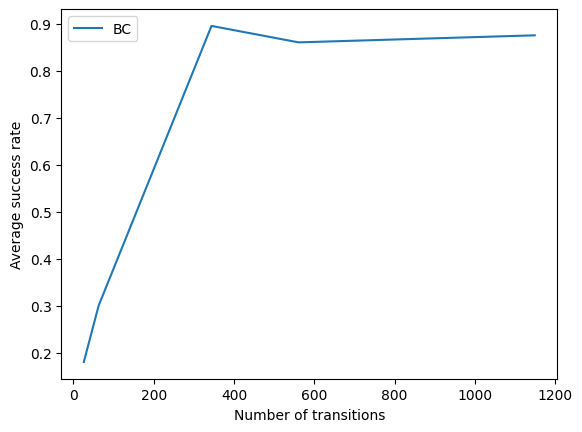

In [21]:
plt.plot(bc_steps, bc_success_rates, label='BC')
plt.xlabel("Number of transitions")
plt.ylabel("Average success rate")
plt.legend()

## DAgger

**Q2:(40 pts total)** As we have learned in the class, behavior cloning suffers from co-variate shift. One way to mitigate this issue is using DAgger. The key idea of DAgger is as follows:
1. Train a behavior cloned policy $\pi_{\theta_k}$ by using an expert dataset $D$
2. Rollout the current policy $\pi_{\theta_k}$ and get a trajectory $(s_0, a_0, s_1, a_1, ...)$.
3. Query the expert again and get the expert actions $(a^*_0, a^*_1, ...)$. We can add these extra expert demonstration data $D_k=(s_0, a^*_0, s_1, a^*_1, ...)$ to $D$: $D=D\cup D_k$.
4. Optimize the current policy again with the aggregated dataset $D$.
5. Repeat step 2 to 4.

In the following section, you will finish implementing the DAgger algorithm.

In [22]:
@dataclass
class DaggerAgent:
    """
    A class for the DAgger (Dataset Aggregation) agent, incorporating both learned and expert policies.

    Attributes:
    - actor (nn.Module): The learned policy model.
    - expert_actor (nn.Module): The expert policy model, used for generating corrective actions.
    - lr (float): The learning rate for the optimizer.

    Methods:
    - __post_init__(): Initializes the agent, moves models to the specified device, and freezes the expert model.
    - get_action(ob, sample=True, *args, **kwargs): Generates an action from the learned policy and retrieves the corresponding expert action. Returns both along with additional action information.
    - optimize(data, **kwargs): Optimizes the learned policy using given data, which includes states and expert actions.
    - save_model(is_best=False, step=None): Saves the state dictionary of the learned policy model.
    """
    actor: nn.Module
    expert_actor: nn.Module
    lr: float

    def __post_init__(self):
        """
        Post-initialization method for the DaggerAgent. This method is automatically called after the object is initialized.

        It moves the actor and expert_actor models to the specified device and freezes the parameters of the expert_actor to prevent it from being updated during training.
        """
        move_to([self.actor, self.expert_actor],
                device=cfg.alg.device)
        freeze_model(self.expert_actor)
        self.optimizer = optim.Adam(self.actor.parameters(),
                                    lr=self.lr)

    @torch.no_grad()
    def get_action(self, ob, sample=True, *args, **kwargs):
        """
        Generates an action for a given observation using the learned policy and also retrieves the corresponding expert action.

        Parameters:
        - ob (np.ndarray): The current state/observation.
        - sample (bool, optional): Whether to sample from the policy distribution (True) or take the mean action (False). Defaults to True.

        Returns:
        - action (np.ndarray): The action generated by the learned policy.
        - action_info (dict): A dictionary containing additional information about the action, such as log probability ('log_prob'), entropy ('entropy'), and the expert action ('exp_act').
        """
        t_ob = torch_float(ob, device=cfg.alg.device)
        # the policy returns a multi-variate gaussian distribution
        act_dist, _ = self.actor(t_ob)
        # sample from the distribution
        action = action_from_dist(act_dist,
                                  sample=sample)
        # get the log-probability of the sampled actions
        log_prob = action_log_prob(action, act_dist)
        # get the entropy of the action distribution
        entropy = action_entropy(act_dist, log_prob)
        action_info = dict(
            log_prob=torch_to_np(log_prob),
            entropy=torch_to_np(entropy),
        )


        action_info['exp_act'] = None
        ##### TODO (10 pts): get the expert action from the expert policy and set "action_info['exp_act']" to this action.
        ##### as before, the policy returns a multi-variate gaussian distribution.
        expert_act_dist, _ = self.expert_actor(t_ob)
        expert_action = action_from_dist(expert_act_dist, sample=sample)
        expert_log_prob = action_log_prob(expert_action, expert_act_dist)
        expert_entropy = action_entropy(expert_act_dist, expert_log_prob)
        action_info['exp_act'] = expert_action
        ###############################################

        return torch_to_np(action), action_info

    def optimize(self, data, **kwargs):
        """
        Optimizes the learned policy using given batch data.

        Parameters:
        - data (dict): A batch of data containing 'state' and 'action', where 'state' is the input to the model and 'action' is the target action from the expert policy.

        Returns:
        - optim_info (dict): A dictionary containing optimization information such as the loss ('loss') and gradient norm ('grad_norm') after the optimization step.
        """
        for key, val in data.items():
            data[key] = torch_float(val, device=cfg.alg.device)
        ob = data['state']
        exp_act = data['action']

        #### TODO (10 pts): optimize the policy

        action_dist,_ = self.actor(ob)
        loss = - action_log_prob(exp_act, action_dist).sum()

        ##############################
        self.optimizer.zero_grad()
        loss.backward()

        grad_norm = clip_grad(self.actor.parameters(),
                              cfg.alg.max_grad_norm)
        self.optimizer.step()

        optim_info = dict(
            loss=loss.item(),
            grad_norm=grad_norm,
        )
        return optim_info

    def save_model(self, is_best=False, step=None):
        """
        Saves the state dictionary of the actor model.

        Parameters:
        - is_best (bool, optional): Flag indicating if the current model is the best model to be saved. Defaults to False.
        - step (int, optional): The current training step or epoch, used for naming the saved model file. Defaults to None.
        """
        data_to_save = {
            'actor_state_dict': self.actor.state_dict()
        }
        save_model(data_to_save, cfg.alg, is_best=is_best, step=step)

In [23]:
@dataclass
class DaggerEngine:
    agent: Any
    runner: Any
    env: Any
    trajs: Any

    def __post_init__(self):
        """
        Initializes the DaggerEngine with the provided components and pre-existing trajectory data.
        """
        self.dataset = TrajDataset(self.trajs)

    def train(self):
        """
        Trains the agent using DAgger (Dataset Aggregation) algorithm. Repeatedly evaluates the current policy,
        collects new trajectories using the current policy augmented with expert actions, and updates the policy based on the aggregated dataset.

        Returns:
        - dataset_sizes (list): A list of dataset sizes after each evaluation interval, indicating the growth of the training dataset over time.
        - success_rates (list): A list of success rates evaluated at each evaluation interval during training.
        """
        success_rates = []
        dataset_sizes = []
        self.cur_step = 0
        for iter_t in tqdm(count()):
            if iter_t % cfg.alg.eval_interval == 0:
                success_rate, ret_mean, ret_std, rets, successes = eval_agent(self.agent,
                                                                              self.env,
                                                                              200,
                                                                              disable_tqdm=True)
                success_rates.append(success_rate)
                dataset_sizes.append(len(self.dataset))
            # rollout the current policy and get a trajectory
            traj = self.runner(sample=True, get_last_val=False, time_steps=cfg.alg.episode_steps)
            # optimize the policy
            self.train_once(traj)
            if self.cur_step > cfg.alg.max_steps:
                break
        return dataset_sizes, success_rates

    def train_once(self, traj):
        """
        Performs a single iteration of policy update using a newly collected trajectory.

        Parameters:
        - traj (Trajectory): A trajectory collected using the current policy, consisting of states, actions, rewards, and additional info.
        """
        self.cur_step += traj.total_steps

        action_infos = traj.action_infos
        exp_act = torch.stack([ainfo['exp_act'] for ainfo in action_infos])

        self.dataset.add_traj(states=traj.obs,
                              actions=exp_act.cpu())
        rollout_dataloader = DataLoader(self.dataset,
                                        batch_size=cfg.alg.batch_size,
                                        shuffle=True,
                                       )
        optim_infos = []
        for oe in range(cfg.alg.opt_epochs):
            for batch_ndx, batch_data in enumerate(rollout_dataloader):
                optim_info = self.agent.optimize(batch_data)
                optim_infos.append(optim_info)

In [24]:
def train_dagger(expert_actor, trajs, actor=None):
    """
    Initializes and trains a DAgger agent using provided trajectories and expert policy.

    Parameters:
    - expert_actor: The expert policy model used to guide the DAgger training process.
    - trajs: Pre-collected trajectories from the expert policy to bootstrap the DAgger algorithm.
    - actor (optional): An initial policy model to start training with. If None, a new actor is created.

    Returns:
    - dagger_agent: The trained DAgger agent.
    - dataset_sizes: A list of dataset sizes through the training, indicating how much data was used at each stage.
    - success_rates: A list of success rates evaluated at various points during training, indicating the performance of the trained agent.
    """
    expert_actor = deepcopy(expert_actor)
    actor = deepcopy(actor)
    set_configs('dagger')
    cfg.alg.episode_steps = 30
    cfg.alg.max_steps = 1200
    cfg.alg.eval_interval = 1
    cfg.alg.log_interval = 1
    cfg.alg.batch_size = 256
    cfg.alg.opt_epochs = 500
    set_random_seed(cfg.alg.seed)
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    if actor is None:
        actor = create_actor(env=env)
    dagger_agent = DaggerAgent(actor=actor, expert_actor=expert_actor, lr=0.001)
    runner = EpisodicRunner(agent=dagger_agent, env=env)
    engine = DaggerEngine(agent=dagger_agent,
                          env=env,
                          runner=runner,
                          trajs=trajs)
    dataset_sizes, success_rates = engine.train()
    return dagger_agent, dataset_sizes, success_rates

In [25]:
set_configs('dagger')
cfg.alg.episode_steps = 30
cfg.alg.max_steps = 1200
cfg.alg.eval_interval = 1
cfg.alg.log_interval = 1
cfg.alg.batch_size = 256
cfg.alg.opt_epochs = 500
print(cfg.alg.max_grad_norm)

[INFO][2024-03-15 03:54:30]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>


      Device:cuda
None


**(20 pts)**: Complete the missing code for `DaggerAgent` (define the loss function and optimize the policy). Train a DAgger agent using `train_dagger` with the behaviorally cloned agent that was trained on just one demonstration as the initial policy, $\pi_{\theta_k}$, the same demonstration as the initial dataset, $D$, and the expert that will provide expert actions as our pre-trained expert model. Note: for train_dagger, pass in the agent's actor, not the agent itself.

Similar to Q1, plot the success rate curves for both DAgger and BC as a function of the number of expert transitions (e.g., dataset size) available at training. Your DAgger and BC curves should reach similarly high performance with enough data while DAgger will reach a high success rate earlier.

In [ ]:
dagger_agent = None
dagger_steps = None
dagger_success_rates = None

#### TODO: train DAgger agent and plot the success rate curves for BC and DAgger together
#### It takes ~20 minutes in T4
dagger_agent, dagger_steps, dagger_success_rates = train_dagger(expert_actor=expert_agent.actor, trajs=expert_trajs)
##########################################################################################

# Save results
with open(f'{PATH}/dagger_agent.pkl', 'wb') as f:
  data = [dagger_agent, dagger_steps, dagger_success_rates]
  pickle.dump(data, f)

In [27]:
# load DAGGER experiments
with open(f'{PATH}/dagger_agent.pkl', 'rb') as f:
    dagger_agent, dagger_steps, dagger_success_rates = pickle.load(f)

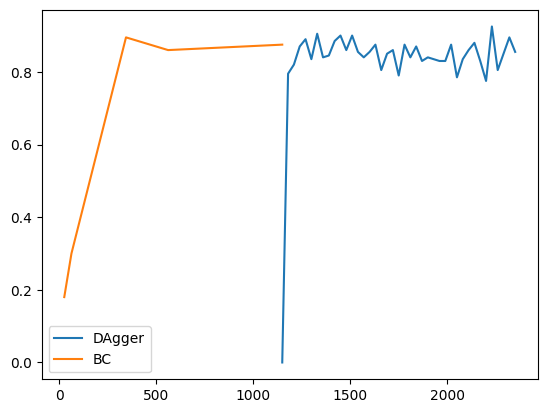

In [28]:
plt.plot(dagger_steps, dagger_success_rates, label='DAgger')
plt.plot(bc_steps, bc_success_rates, label='BC')
plt.legend()

# RL Finetune

**Q3 (40 pts total):** In DAgger, an expert is required to query the optimal action at every step during training time. However, an expert may not always be available. In the context of autonomous vehicles, for behavior cloning an expert driver is only required to collect the initial dataset of expert demonstrations while for DAgger we would need an expert to see everything the vehicle does and relabel the data in a continuous cycle during all of training. Clearly this approach does not scale, especially if obtaining these expert labels is costly.

In such cases where an expert is unavailable during the training process, if we have access to the reward function in addition to a few demonstrations, then we can combine RL and behavior cloning to improve performance.

In the following section, we will use PPO to finetune the behavior-cloned policy. We have provided you with a `train_ppo` function that you are free to modify. Note that typically we use multi-process to roll out many agents in parallel in PPO. It typically leads to faster and more stable learning. One way to get around parallelization is to have one policy update step after collecting many rollouts with the same policy. Here, our environment terminates after $30$ steps and gets reset, but `episode_steps` is set to 900, so we will have $30$ agents' rollout experience for every single step of policy optimization.

In [29]:
#### TODO: use PPO to finetune the behavior cloned policies (the ones
#### that are trained with 1 and 3 demonstration trajectories respectively)
#### There is no implementation question in this code block.
def train_ppo(actor=None, save_dir=None, max_steps=1000000):
    """
    Finetunes a policy using the Proximal Policy Optimization (PPO) algorithm.

    Parameters:
    - actor (optional): An initial policy model to finetune. If None, a new actor is created.
    - save_dir (str, optional): Directory to save trained models and logs.
    - max_steps (int, optional): The maximum number of steps to run the PPO training.

    Returns:
    - agent: The trained PPO agent.
    - engine: The PPO training engine used for the training process.
    - save_dir: The directory where the trained models and logs are saved.
    """
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 900
    cfg.alg.max_steps = max_steps
    cfg.alg.deque_size = 20
    cfg.alg.eval_interval = 10
    cfg.alg.log_interval = 1
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/rl_finetune' if save_dir is None else f'/{save_dir}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    ob_size = env.observation_space.shape[0]

    if actor is None:
        actor = create_actor(env=env)
    actor = deepcopy(actor)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()
    return agent, engine, cfg.alg.save_dir

**(20 pts)**: Compare the learning curves (both the return curve and the success rate curve) of the following two cases:

1. A policy trained from scratch for the pusher environment
2. A finetuned behavior-cloned policy with RL (specifically here, use the BC agent trained with 3 demonstration trajectories from Q1, i.e., bc_agents[3])
  *  This should be a fixed value across all steps.

For 10k time steps and 300k time steps, train both agents and make two separate plots for a total of 4 plots. One analyzing the return and the other analyzing success rates.

Return Plot: the number of steps (# of steps) X (return for rl_scratch and rl_finetune). Plot the average return with its uncertainty (standard deviation) as a shade with alpha=0.25

Success Rate Plot: the number of steps (# of steps) X (success for rl_scratch and rl_finetune). Include the average success rate for the **BC agent** trained on 3 demonstrations without any fine-turning in this plot as a separate color (you should've cached this from Q1).

*Note: we provide the data for the 300k training, no need to implement the 300k trained agents yourself*

In [ ]:
# It takes ~3 minutes in T4 for 10K steps.
# TODO: Plots for 10k time steps. The `plot_curves()` function may be useful.

_, _, save_dir_scratch_ = train_ppo(actor=None, save_dir=None, max_steps=10000)
scratch_steps_, scratch_returns_, scratch_success_rate_ = read_tf_log(save_dir_scratch_)


_, _, save_dir_finetune_ = train_ppo(actor=bc_agents[3].actor, save_dir=None, max_steps=10000)
finetune_steps_, finetune_returns_, finetune_success_rate_ = read_tf_log(save_dir_finetune_)

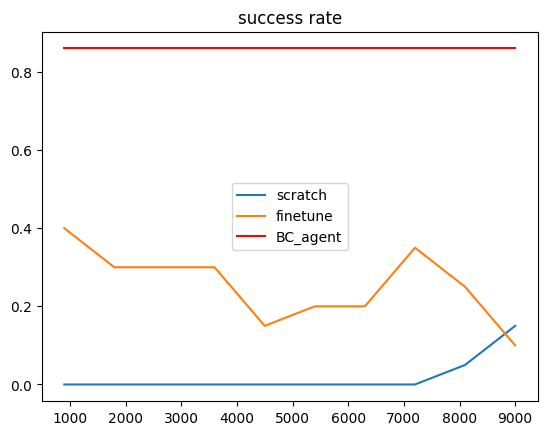

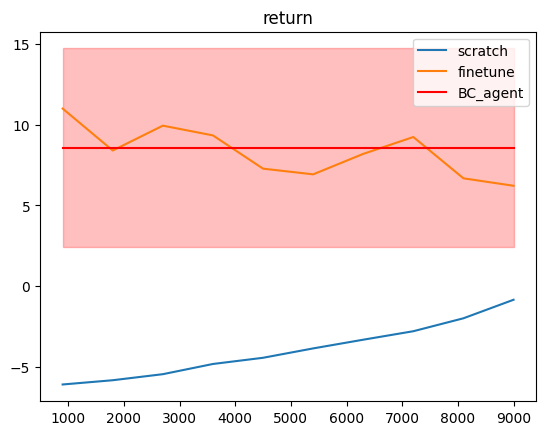

In [51]:
plt.figure()
plt.plot(scratch_steps_, scratch_success_rate_, label = 'scratch')
plt.plot(finetune_steps_, finetune_success_rate_, label = 'finetune')
plt.plot(finetune_steps_, np.ones(len(finetune_steps_))*bc_success_rates[3], color='r', label = 'BC_agent')
plt.title('success rate')
plt.legend()
plt.show()

plt.figure()
plt.plot(scratch_steps_, scratch_returns_, label = 'scratch')
plt.plot(finetune_steps_, finetune_returns_, label = 'finetune')
plt.plot(finetune_steps_, np.ones(len(finetune_steps_))*np.mean(bc_rets[3]), color='r', label = 'BC_agent')
plt.fill_between(finetune_steps_, np.mean(bc_rets[3])+np.std(bc_rets[3]), np.mean(bc_rets[3])-np.std(bc_rets[3]), color='r', alpha=0.25)

plt.title('return')
plt.legend()
plt.show()

In [ ]:
# Download the results of the model trained with only PPO and finetuned trained for 300k steps
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1GNNd4iShD6fgsjLw6GJSVj169JlPLDZt' -O rl_scratch_results.csv
!wget --no-check-certificate -r  'https://drive.google.com/uc?export=download&id=10EWpvU0pS5vS1zx1oKytNwYRQJjsd3XS' -O rl_finetune_results.csv

In [53]:
# load data for 300k steps
df = pd.read_csv("rl_scratch_results.csv")
scratch_steps, scratch_returns, scratch_success_rate = df["steps"], df["returns"], df["success_rate"]

df = pd.read_csv("rl_finetune_results.csv")
finetune_steps, finetune_returns, finetune_success_rate = df["steps"], df["returns"], df["success_rate"]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


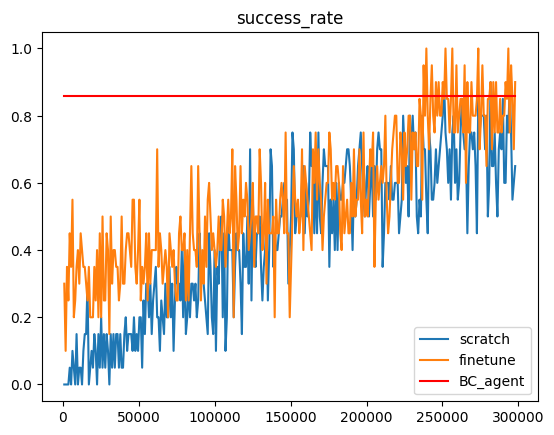

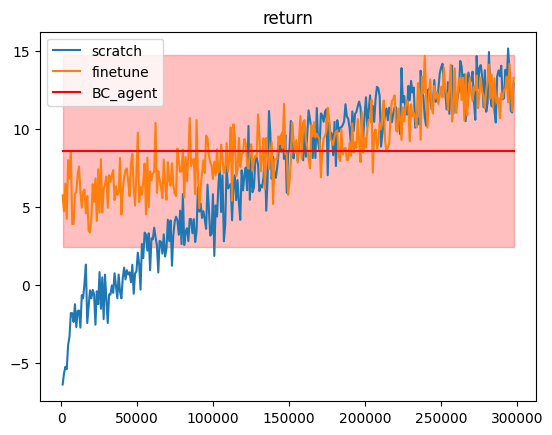

In [54]:
# TODO: Plots for 300k time steps.
plt.figure()
plt.plot(scratch_steps, scratch_success_rate, label = 'scratch')
plt.plot(finetune_steps, finetune_success_rate, label = 'finetune')
plt.plot(finetune_steps, np.ones(len(finetune_steps))*bc_success_rates[3], color='r', label = 'BC_agent')
plt.title('success_rate')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(scratch_steps, scratch_returns, label='scratch')
plt.plot(finetune_steps, finetune_returns, label='finetune')
plt.plot(finetune_steps, np.ones(len(finetune_steps))*np.mean(bc_rets[3]), color='r', label = 'BC_agent')
plt.fill_between(finetune_steps, np.mean(bc_rets[3])+np.std(bc_rets[3]), np.mean(bc_rets[3])-np.std(bc_rets[3]), color='r', alpha=0.25)
plt.title('return')
plt.legend(loc='best')
plt.show()

**Q (10 pts):** Do you see any difference in performance at the end of training? Why do `rl_scratch` and `rl_finetune` converge to the same success rate?

**A:** Based on the data, both averaged return and success rate are almost the same. This is because RL agent got enough experiences for training to get the best reward at the end even without the expert's input. I think this was possible because the environment that the agent is learnig is pretty simple.

**Q (10 pts):** What about in comparison to the BC agent without fine-tuning? If so, describe them in detail.

**A:** BC agent without fine-tuning has similar success rate but has lower average return compared to others. This means that RL-assisted algorithm can be more robust.  


# Suboptimal Demonstrations

**Q4 (35 pts total)**: In many cases, we might not have a good expert model available. Thus, the demonstrations we get from the expert will not be optimal. In the following section, we will use a sub-optimal expert model to generate the demonstration data, use such data to train a BC agent, and see if the policy can be improved by RL.

In [ ]:
# Download the suboptimal expert model
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1AzWwGkOcZxrx43kNhD-7TPj06bIKRSXX' -O pusher_suboptimal_expert_model.pt

In [67]:
# same as before, let's load a suboptimal expert model
set_configs()
env = make_vec_env(cfg.alg.env_name,
                   cfg.alg.num_envs,
                   seed=cfg.alg.seed)
sub_expert_agent = load_expert_agent(env, device=cfg.alg.device, expert_model_path='pusher_suboptimal_expert_model.pt')

[INFO][2024-03-15 06:04:50]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-15 06:04:50]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-15 06:04:50]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
Loading expert model from: pusher_suboptimal_expert_model.pt.


In [68]:
# let's see how good the expert model is
# It takes < 1 minute in T4
success_rate, ret_mean, ret_std, rets, successes = eval_agent(sub_expert_agent, env, 500)
print(f'Expert policy success rate:{success_rate}')

Run:   0%|          | 0/500 [00:00<?, ?it/s]

Expert policy success rate:0.57


In [69]:
# let's use this suboptimal expert model to generate some demonstrations
# It takes < 1 minute in T4
sub_expert_trajs = generate_demonstration_data(expert_agent=sub_expert_agent,
                                               env=env,
                                               num_trials=50)

Run:   0%|          | 0/50 [00:00<?, ?it/s]

**Q4.1 (10 pts)**: Similar to Q1, train a BC policy using `train_bc_agent` with $1, 3, 15, 25, 50$ suboptimal trajectories. Once you have trained the BC policy (cloned on suboptimal data), evaluate your policy on $200$ episodes and plot the average success rate (returned by 'eval_agent') as a function of the number of expert transitions used in training.

In [70]:
num_trajs = [1, 3, 15, 25, 50]
bc_success_rates_sub = []
bc_steps_sub = []
bc_agents_sub = dict()

# TODO same as before, run BC with 1, 3, 15, 25, 50 demonstrations respectively
# It takse ~5 minutes in T4

for num_traj in num_trajs:
    bc_agent_sub = BasicAgent(create_actor(env=env))
    sub_trajs_partial = sub_expert_trajs[:num_traj]
    agent_tmp, logs, step_len = train_bc_agent(agent=bc_agent_sub, trajs=sub_trajs_partial)

    success_rate, _, _, rets, _ = eval_agent(agent_tmp, env, num_trials=200)
    bc_agents_sub[num_traj] = agent_tmp
    bc_success_rates_sub.append(success_rate)
    bc_steps_sub.append(step_len)

###########################################################
with open(f'{PATH}/bc_agent_sub.pkl', 'wb') as f:
    data = [bc_agents_sub, bc_steps_sub, bc_success_rates_sub]
    pickle.dump(data, f)

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

Run:   0%|          | 0/200 [00:00<?, ?it/s]

In [71]:
with open(f'{PATH}/bc_agent_sub.pkl', 'rb') as f:
    bc_agents_sub, bc_steps_sub, bc_success_rates_sub = pickle.load(f)

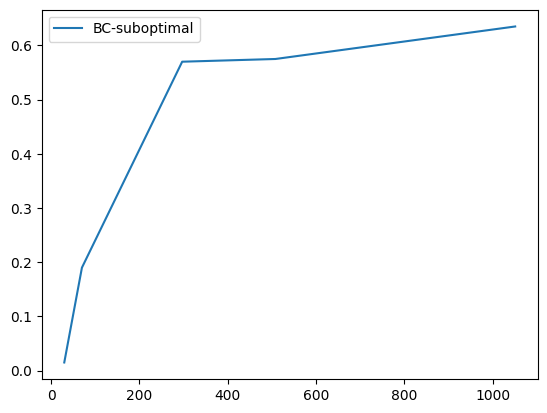

In [72]:
plt.plot(bc_steps_sub, bc_success_rates_sub, label='BC-suboptimal')
plt.legend()

**Q4.2 (25 pts)**: Similar to in Q3, run RL-finetune with the behavior-cloned policy trained from 3 suboptimal demonstration trajectories using 10k and 300k steps. Plot the return and success rate of the agent. On the same graph, also plot the same values for the 'from scratch' and RL-finetuned agents trained on 3 optimal demonstrations policies with the corresponding amount of steps. You should have a total of 4 graphs.
* Return Plot: the number of steps (# of steps) X return for *rl_scratch, rl_finetune_suboptimal, rl_finetune_optimal*
* Second Plot: the number of steps (# of steps) X success rate for *rl_scratch, rl_finetune_suboptimal, rl_finetune_optimal*

Does RL-finetune help improve the policy performance? Describe your observations.

**A**: We have already seen that RL-finetune can provide better return compared to BC. Based on the observation below, RL-finetune with the suboptimal demonstration also provides similar improvements compared to optimal case. Therefore we can conclude RL-finetune can help improve the policy performance.

In [ ]:
!wget --no-check-certificate -r  'https://drive.google.com/uc?export=download&id=1uxWNFfOswOW7qlEPCJgPdr_xefvJBUkx' -O rl_finetune_sub_results.csv

# load data for finetune suboptimal agent trained on 300k steps
df = pd.read_csv("rl_finetune_sub_results.csv")
finetune_sub_steps, finetune_sub_returns, finetune_sub_success_rate = df["steps"], df["returns"], df["success_rate"]

In [ ]:
# TODO: Plot comparison of 3 agents trained with 10k and 300k steps. 4 graphs total.

_, _, save_dir_finetune_sub_ = train_ppo(actor=bc_agents_sub[3].actor, save_dir=None, max_steps=10000)
finetune_sub_steps_, finetune_sub_returns_, finetune_sub_success_rate_ = read_tf_log(save_dir_finetune_sub_)

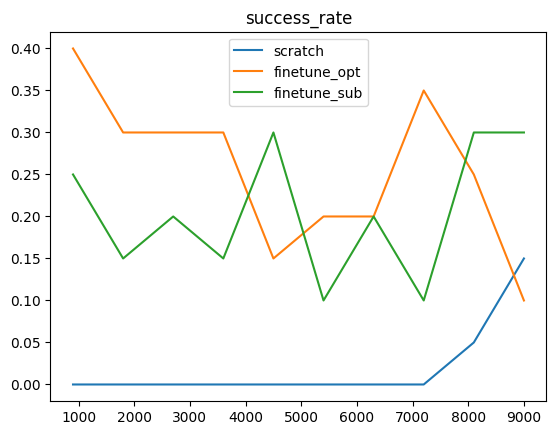

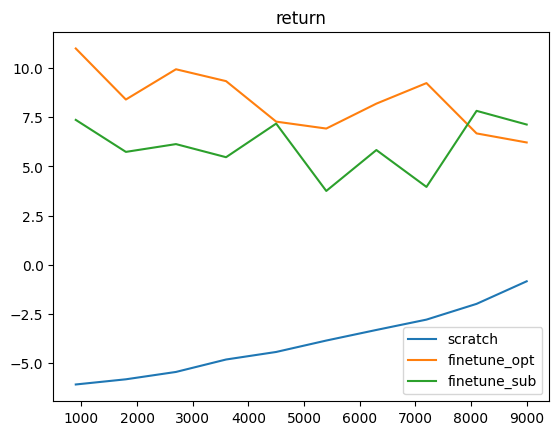

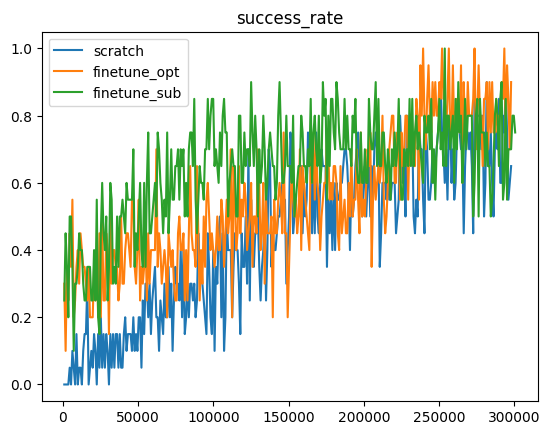

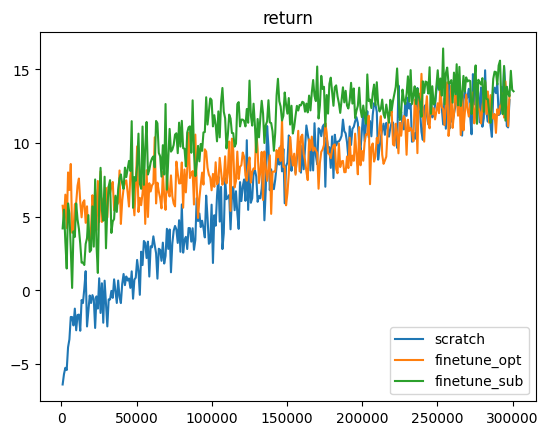

In [76]:
plt.figure()
plt.plot(scratch_steps_, scratch_success_rate_, label = 'scratch')
plt.plot(finetune_steps_, finetune_success_rate_, label = 'finetune_opt')
plt.plot(finetune_sub_steps_, finetune_sub_success_rate_, label = 'finetune_sub')
plt.title('success_rate')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(scratch_steps_, scratch_returns_, label='scratch')
plt.plot(finetune_steps_, finetune_returns_, label='finetune_opt')
plt.plot(finetune_sub_steps_, finetune_sub_returns_, label='finetune_sub')
plt.title('return')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(scratch_steps, scratch_success_rate, label = 'scratch')
plt.plot(finetune_steps, finetune_success_rate, label = 'finetune_opt')
plt.plot(finetune_sub_steps, finetune_sub_success_rate, label = 'finetune_sub')
plt.title('success_rate')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(scratch_steps, scratch_returns, label='scratch')
plt.plot(finetune_steps, finetune_returns, label='finetune_opt')
plt.plot(finetune_sub_steps, finetune_sub_returns, label='finetune_sub')
plt.title('return')
plt.legend(loc='best')
plt.show()

# More Advanced Ideas (Bonus, Optional)

So far, we have seen how behavior cloning, DAgger, and behavior cloning with RL finetuning work. There are many more ideas one can try to make use of the demonstration data. For example, we can optimize the policy with the RL loss and behavior-cloning loss together as done in this work - [Learning Complex Dexterous Manipulation with
Deep Reinforcement Learning and Demonstrations, Equation (6)](https://arxiv.org/pdf/1709.10087.pdf) - discussed in lecture.

Try to implement it yourself on the Pusher environment. You are free to use any publicly avaiable RL library. You can also try out a sparse-reward setting for the Pusher environment with expert demonstrations.

**Q (20 pts)**: Plot the return as well as the success rate curves. Compare the curves with the curves from the RL-scratch (training with RL from scratch) experiment.

**A**:


# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://forms.gle/8f3yTvtTSME9mWW19) and enter the code below to receive credit. Thanks!

**Code:** oh_reward_my_reward